<a href="https://colab.research.google.com/github/adriaat/temporarynotebook/blob/main/example_RoA_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Executing a Rain over Africa retrieval

In this notebook I will walk you through finding, downloading, executing, and saving a Rain over Africa (RoA) retrieval, using a free Google Colab GPU runtime and the latest Meteosat Second Generation image.

First, we select the GPU runtime. At the time of writing, this is "T4 GPU".

Note that the code in this notebook is adapted to the limits of this runtime, shown below:

In [ ]:
%%bash
echo "Today is `date`"
echo
lscpu | grep -E 'Model name|^CPU\(s\):|MHz' | awk '{$1=$1; print}'
echo
echo "System memory:"
awk '/MemTotal/ {printf "%.2f GiB\n", $2 / 1024 / 1024}' /proc/meminfo
echo
echo "GPU:"
nvidia-smi --query-gpu=gpu_name,memory.total --format=csv,noheader
echo
echo "Python version: `python --version`"

Today is Tue Feb 25 12:28:20 PM UTC 2025

CPU(s): 2
Model name: Intel(R) Xeon(R) CPU @ 2.00GHz

System memory:
12.67 GiB

GPU:
Tesla T4, 15360 MiB

Python version: Python 3.11.11


but if you want to run using other system resources, i.e. a small GPU and more RAM, it is likely doable.

We begin by setting up the Google Colab environment:

In [ ]:
%%bash
pip install git+https://github.com/SEE-GEO/roa cmocean eumdac cartopy

  Cloning https://github.com/SEE-GEO/roa to /tmp/pip-req-build-0kds64an
  Resolved https://github.com/SEE-GEO/roa to commit c09708cd1f6bac1809b547e71b4887d8ae3b9ff3
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Cloning https://github.com/simonpf/ipwgml (to revision b9dfd64bd13e32aa54929b2451d87ac66587f378) to /tmp/pip-install-e33fuyt9/ipwgml_5106bbf8766840c4a3ed09223a93be95
  Resolved https://github.com/simonpf/ipwgml to commit b9dfd64bd13e32aa54929b2451d87ac66587f378
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyp

  Running command git clone --filter=blob:none --quiet https://github.com/SEE-GEO/roa /tmp/pip-req-build-0kds64an
  Running command git clone --filter=blob:none --quiet https://github.com/simonpf/ipwgml /tmp/pip-install-e33fuyt9/ipwgml_5106bbf8766840c4a3ed09223a93be95
  Running command git rev-parse -q --verify 'sha^b9dfd64bd13e32aa54929b2451d87ac66587f378'
  Running command git fetch -q https://github.com/simonpf/ipwgml b9dfd64bd13e32aa54929b2451d87ac66587f378
  Running command git checkout -q b9dfd64bd13e32aa54929b2451d87ac66587f378


In [ ]:
# Import libraries
import datetime
import getpass
import hashlib
from pathlib import Path
import shutil
import sys
import time

import cmocean
import eumdac
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import quantnn
import torch
import tqdm
import xarray as xr

# RoA library
from roa import (
    MSGNative,
    QUANTILES,
    prepare_dataset_for_network,
    Tiler
)
from roa.data import SEVIRI_0DEG_AREADEF

print(f"Python version {sys.version}\n")
for module in [eumdac, matplotlib, np, torch, xr]:
    print(f"{module.__name__}: {module.__version__}")

Python version 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]

eumdac: 3.0.0
matplotlib: 3.10.0
numpy: 1.26.4
torch: 2.5.1+cu124
xarray: 2025.1.2


`roa` is at commit

In [ ]:
!git ls-remote https://github.com/SEE-GEO/roa.git HEAD

c09708cd1f6bac1809b547e71b4887d8ae3b9ff3	HEAD


Let's say we want to run a retrieval for the latest Meteosat Second Generation scan. We search for the latest 15 minutes in UTC:

In [ ]:
dtend = datetime.datetime.now(datetime.UTC)
dtstart = dtend - datetime.timedelta(minutes=15)

and use eumdac to search for the file (you need [EUMETSAT Data Store authentication](https://user.eumetsat.int/resources/user-guides/data-store-detailed-guide#ID-Authentication)):

In [ ]:
# Get access to EUMETSAT Data Store
token = eumdac.AccessToken(
    (
        getpass.getpass("EUMETSAT Consumer key: "),
        getpass.getpass("EUMETSAT Consumer secret: ")
    )
)
datastore = eumdac.DataStore(token)
selected_collection = datastore.get_collection('EO:EUM:DAT:MSG:HRSEVIRI')

nat_files = [f for f in list(selected_collection.search(dtstart=dtstart, dtend=dtend))]

EUMETSAT Consumer key: ··········
EUMETSAT Consumer secret: ··········


The variable `nat_files` contains all MSG observations at 0 degree in the last 15 minutes, which we expect to be 1

In [ ]:
assert len(nat_files) == 1

We will download the file and execute the retrieval on it.

But first, we download the RoA network:

In [ ]:
!wget -O /content/network_CPU.pt https://raw.githubusercontent.com/SEE-GEO/roa/refs/heads/main/data/network_CPU.pt

with open('/content/network_CPU.pt', 'rb') as handle:
  assert hashlib.md5(handle.read()).hexdigest() == r"135d57c80d10417ce98578d9a1f7d5dd"

--2025-02-25 12:32:54--  https://raw.githubusercontent.com/SEE-GEO/roa/refs/heads/main/data/network_CPU.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2589836 (2.5M) [application/octet-stream]
Saving to: ‘/content/network_CPU.pt’

/content/network_CP 100%[===================>]   2.47M  --.-KB/s    in 0.03s   

2025-02-25 12:32:55 (92.4 MB/s) - ‘/content/network_CPU.pt’ saved [2589836/2589836]



In [ ]:
# Load model on the GPU
model_gpu = torch.jit.load(
    '/content/network_CPU.pt',
    map_location=torch.device('cuda')
)

In [ ]:
# Working path
opath = Path('/content/tmp')
opath.mkdir(exist_ok=True)

# For measuring times
times = dict()

In [ ]:
# Download the file
t = time.time()
p = nat_files[0]
entry = f'{str(p)}.nat'
with p.open(entry=entry) as fsrc:
    with open(opath / entry, 'wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)
times['download'] = time.time() - t

In [ ]:
# Read data
t = time.time()
ds = MSGNative(opath / entry).get_dataset().load()
ds = ds.assign_coords({"nat_file": entry}).expand_dims("nat_file")
times['read'] = time.time() - t

In [ ]:
# Prepare the dataset for the network
t = time.time()
x = prepare_dataset_for_network(ds.sel(nat_file=entry))[None, ...]
tiler = Tiler(x)

# Get tiles and put them in the batch dimension
x = torch.stack(
        [tiler.get_tile(i,j) for i in range(tiler.M) for j in range(tiler.N)],
        dim=0
    )
x = x.view(-1, *x.shape[2:])
times['preprocess'] = time.time() - t

In [ ]:
# Run inference in GPU
t = time.time()

# Note: three options, depending on the GPU and system memory available:
# (a) Run the whole batch at once (GPU expensive)
#   y_hat = model_gpu(x.cuda()))
# (b) Run in batches and add the results to a preallocated tensor in GPU
#   (less GPU expensive)
# (c) Run in batches and add the results to a preallocated tensor in CPU
#   (even less GPU expensive, since we don't accumulate the results in the GPU,
#   at the expense of more system RAM usage).
#   This option runs out of memory in Google Colab with the standard CPU runtime
#
# We take option (b)
# Note: we don't need to preallocate the tensor, but it's more memory-efficient

#  We can also reduce the memory footprint of the last two options
#  with dtype=torch.bfloat16 or torch.float16
dtype = torch.float32

# Preallocate output tensor
y_hat = torch.full(
    (len(x), QUANTILES.size, *tiler.tile_size),
    torch.nan,
    dtype=dtype,
    device=torch.device('cuda')
)

bs = 1 # batch size -- higher values can be used
for i in tqdm.tqdm(range(0, len(x), bs), desc="Inference"):
    y_hat[i:(i+bs)] = model_gpu(x[i:(i+bs)].cuda()).to(dtype)

times['retrieval_gpu'] = time.time() - t

Inference: 100%|██████████| 1435/1435 [00:23<00:00, 60.49it/s]


In [ ]:
# Assemble the tiles
t = time.time()
y_hat = y_hat.view(tiler.M, tiler.N, 1, *y_hat.shape[1:])
y_hat = tiler.assemble(y_hat)
times['assembly'] = time.time() - t

# update dtype if necessary for the next steps:
if y_hat.dtype != torch.float32:
    y_hat = y_hat.to(torch.float32)

# and place y_hat in CPU
y_hat = y_hat.cpu().numpy()

In [ ]:
# ====================
# Compute statistics
t = time.time()
# The expected value
# As the inference step, we process the retrievals in batches
# (10 batches) due to the available resources in this runtime
spatial_shape = y_hat.shape[-2:]
y_hat = y_hat.reshape(1, QUANTILES.size, -1)
y_mu = np.concatenate(
    [
        quantnn.quantiles.posterior_mean(
            _y_hat,
            QUANTILES.astype('float32'),
            quantile_axis=1
        )
        for _y_hat in np.array_split(y_hat, 10, axis=-1)
    ],
    axis=-1
).reshape(1, *spatial_shape)
times['statistic (mu)'] = time.time() - t

/usr/local/lib/python3.11/dist-packages/quantnn/quantiles.py:90: RuntimeWarning: invalid value encountered in subtract
  dx = y_pred[selection_r] - y_pred[selection_c]
/usr/local/lib/python3.11/dist-packages/quantnn/quantiles.py:101: RuntimeWarning: invalid value encountered in subtract
  dx = y_pred[selection_c] - y_pred[selection_l]


In [ ]:
# And quantiles at level tau = 16% and 84%
# we could use quantnn.quantiles.posterior_quantiles,
# but these quantile levels are directly given by the RoA network
t = time.time()
tau = np.array([0.16, 0.84])
y_tau = y_hat[:, np.isin(QUANTILES, tau)].reshape(1, tau.size, *spatial_shape)
times['statistic (quantiles)'] = time.time() - t

In [ ]:
# ====================
# Create an xarray.Dataset with the statistic computed
t = time.time()
ds_out = xr.Dataset(
    data_vars={
        "hat_y_mu": (["nat_file", "y", "x"], y_mu),
        "hat_y_tau": (["nat_file", "tau", "y", "x"], y_tau)
    },
    coords={
        "x": ds.x.data,
        "y": ds.y.data,
        "nat_file": [entry],
        "tau": tau,
    }
)

# and "save" it, just as an example
# Clear attributes that are not serializable
for v in ds_out:
    ds_out[v].attrs = {}
ds_out.to_netcdf(opath / f'{entry}.nc') # .to_zarr(opath / f'{entry}.zrr') for cloud-optimized
times['save'] = time.time() - t

Show how long it took each step:

In [ ]:
for k, v in times.items():
    print(f'{k}: {v:.2f} [s]')

download: 6.66 [s]
read: 12.10 [s]
preprocess: 3.01 [s]
retrieval_gpu: 23.74 [s]
assembly: 3.98 [s]
statistic (mu): 16.65 [s]
statistic (quantiles): 0.02 [s]
save: 0.26 [s]


Let's visualize the input and the retrieved $\hat{y}_{\mu}$, $\hat{y}_{16\%}$, and $\hat{y}_{84\%}$:

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


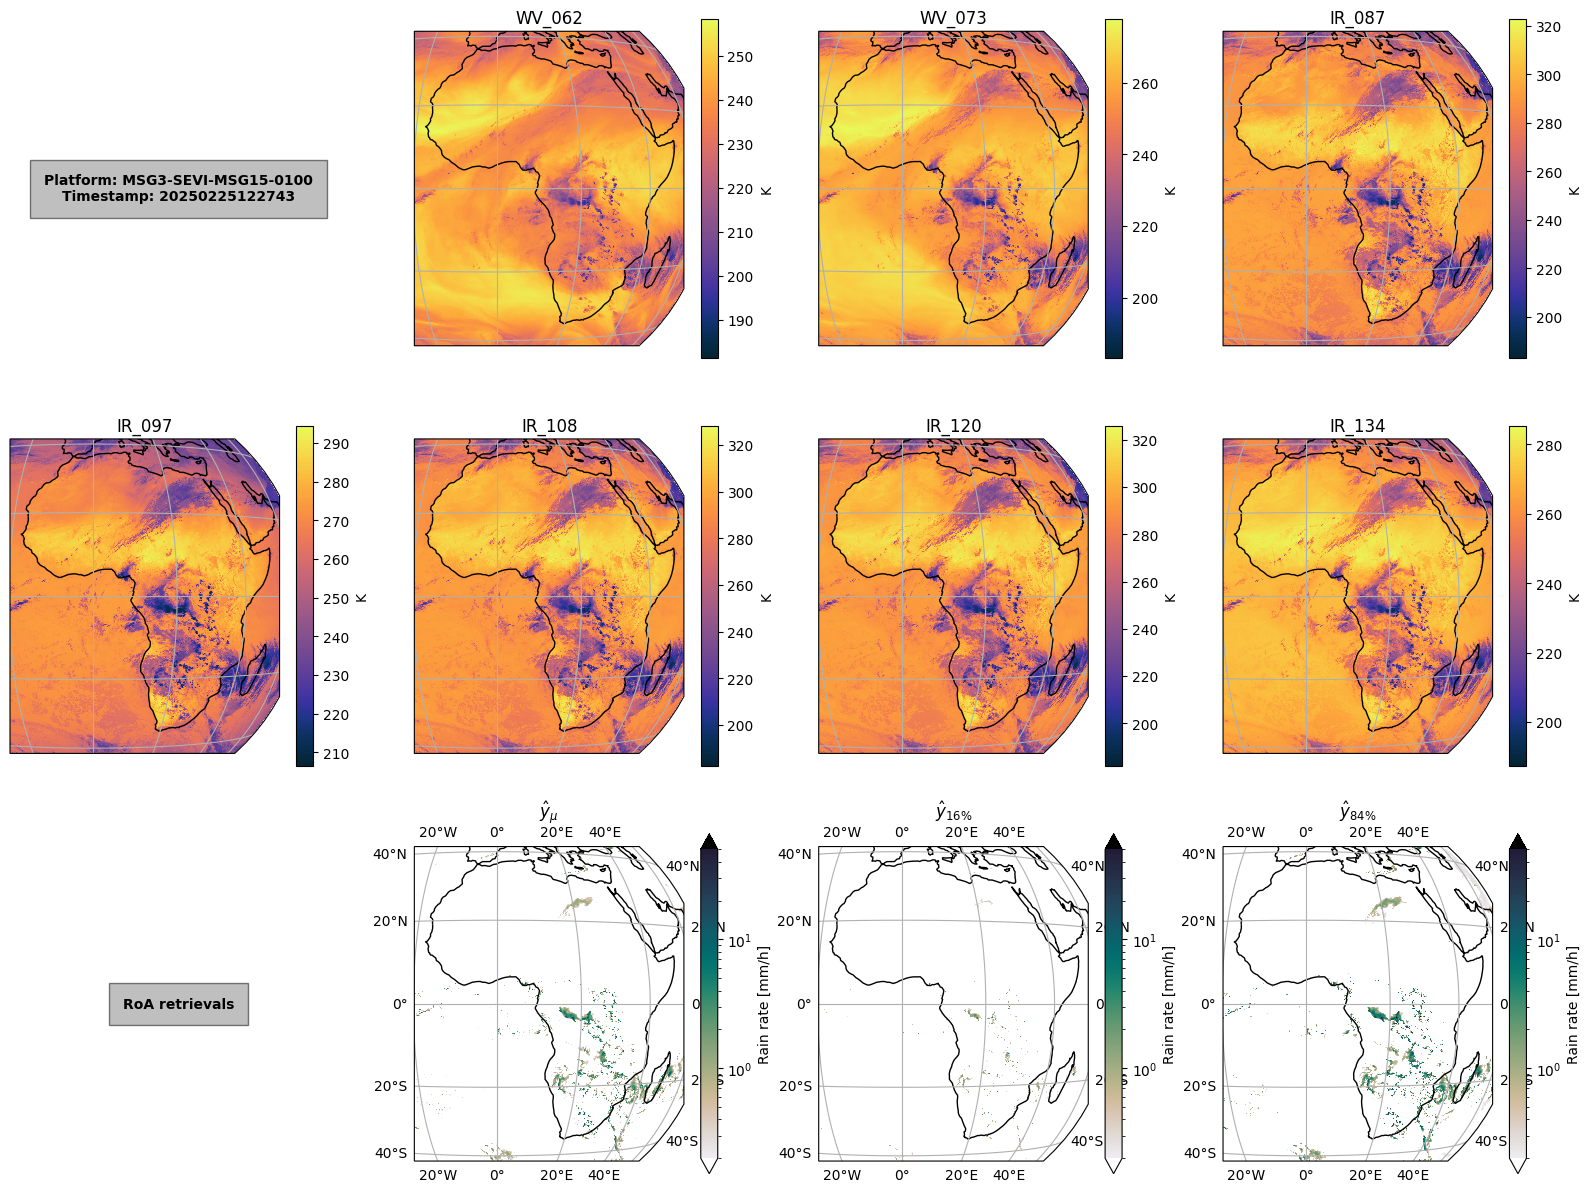

In [ ]:
crs = SEVIRI_0DEG_AREADEF.to_cartopy_crs()
fig, axs = plt.subplots(ncols=4, nrows=3, subplot_kw={'projection': crs}, figsize=(20, 15))

ax = axs.ravel()[0]
ax.set_axis_off()
instrument, timestamp = ds_out.nat_file.data.item().replace('.nat','').split('-NA-')
ax.text(
    0.5, 0.5,
    f'Platform: {instrument}\nTimestamp: {timestamp.split(".")[0]}',
    ha='center',
    va='center',
    transform=ax.transAxes,
    bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10},
    fontweight='bold'
)

kwargs_bts = {'transform': crs, 'cmap': cmocean.cm.thermal}
for i, k in enumerate(list(ds)[:7], start=1):
    ax = axs.ravel()[i]
    x, y = np.broadcast_arrays(ds.x.data[None, :], ds.y.data[:, None])
    m = ax.pcolormesh(x, y, ds[k].sel(nat_file=entry).data, **kwargs_bts)
    ax.coastlines()
    ax.gridlines()
    fig.colorbar(m, ax=ax, label=ds[k].units)
    ax.set_title(k)

ax = axs.ravel()[-4]
ax.set_axis_off()
instrument, timestamp = ds_out.nat_file.data.item().replace('.nat','').split('-NA-')
ax.text(
    0.5, 0.5,
    'RoA retrievals',
    ha='center',
    va='center',
    transform=ax.transAxes,
    bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10},
    fontweight='bold'
)

kwargs_roa = {
    'transform': crs,
    'norm': matplotlib.colors.LogNorm(vmin=0.2, vmax=50),
    'cmap': cmocean.cm.rain
}

ax = axs.ravel()[-3]
x, y = np.broadcast_arrays(ds_out.x.data[None, :], ds_out.y.data[:, None])
m = ax.pcolormesh(x, y, ds_out.hat_y_mu.sel(nat_file=entry).data, **kwargs_roa)
m.cmap.set_under('white')
m.cmap.set_over('black')
ax.coastlines()
ax.gridlines(draw_labels=True)
fig.colorbar(m, ax=ax, label='Rain rate [mm/h]', extend='both')
ax.set_title(r'$\hat{y}_{\mu}$')

for i, t in enumerate(tau):
  ax = axs.ravel()[-2 + i]
  x, y = np.broadcast_arrays(ds_out.x.data[None, :], ds_out.y.data[:, None])
  m = ax.pcolormesh(x, y, ds_out.hat_y_tau.sel(nat_file=entry, tau=t).data, **kwargs_roa)
  m.cmap.set_under('white')
  m.cmap.set_over('black')
  ax.coastlines()
  ax.gridlines(draw_labels=True)
  fig.colorbar(m, ax=ax, label='Rain rate [mm/h]', extend='both')
  ax.set_title(rf'$\hat{{y}}_{{{int(t*100)}\%}}$')

plt.show()